<a href="https://colab.research.google.com/github/Vamsi995/Covariance-Temporal-GCN-for-Traffic-Forecasting/blob/main/TGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -c https://github.com/lehaifeng/T-GCN/blob/master/data/los_adj.csv

--2024-11-30 01:12:48--  https://github.com/lehaifeng/T-GCN/blob/master/data/los_adj.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘los_adj.csv’

los_adj.csv             [  <=>               ] 490.45K  1.30MB/s    in 0.4s    

2024-11-30 01:12:49 (1.30 MB/s) - ‘los_adj.csv’ saved [502217]



In [ ]:
!wget -c https://github.com/lehaifeng/T-GCN/blob/master/data/los_speed.csv

--2024-11-30 01:12:49--  https://github.com/lehaifeng/T-GCN/blob/master/data/los_speed.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘los_speed.csv’

los_speed.csv           [  <=>               ] 284.16K   942KB/s    in 0.3s    

2024-11-30 01:12:50 (942 KB/s) - ‘los_speed.csv’ saved [290984]



In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl

def load_sz_data():
    sz_adj = pd.read_csv(r'/content/sz_adj.csv',header=None)
    adj = np.asarray(sz_adj)
    sz_tf = pd.read_csv(r'/content/sz_speed.csv')
    return sz_tf, adj

def load_los_data():
    los_adj = pd.read_csv(r'/content/los_adj.csv',header=None)
    adj = np.asarray(los_adj)
    los_tf = pd.read_csv(r'/content/los_speed.csv')
    return los_tf, adj


def preprocess_data(data, time_len, rate, seq_len, pre_len):
    train_size = int(time_len * rate)
    train_data = data[0:train_size]
    test_data = data[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])

    trainX1 = np.array(trainX)
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

In [ ]:
speed, adj = load_los_data()

In [ ]:
adj.shape

(207, 207)

In [ ]:
speed.shape

(2016, 207)

In [ ]:
import numpy as np
import pandas as pd
import torch


def load_features(feat_path, dtype=np.float32):
    feat_df = pd.read_csv(feat_path)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj


def generate_dataset(
    data, cov_data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    """
    :param data: feature matrix
    :param seq_len: length of the train data sequence
    :param pre_len: length of the prediction data sequence
    :param time_len: length of the time series in total
    :param split_ratio: proportion of the training set
    :param normalize: scale the data to (0, 1], divide by the maximum value in the data
    :return: train set (X, Y) and test set (X, Y)
    """
    if time_len is None:
        time_len = data.shape[0]
    if normalize:
        max_val = np.max(data)
        data = data / max_val
    train_size = int(time_len * split_ratio)
    train_data = data[:train_size]
    train_cov = cov_data[:train_size]
    test_data = data[train_size:time_len]
    test_cov = cov_data[train_size:time_len]
    train_X, train_Y, test_X, test_Y = list(), list(), list(), list()
    for i in range(len(train_data) - seq_len - pre_len):
        train_X.append(np.array(train_cov[i : i + seq_len]))
        train_Y.append(np.array(train_data[i + seq_len : i + seq_len + pre_len]))
    for i in range(len(test_data) - seq_len - pre_len):
        test_X.append(np.array(test_cov[i : i + seq_len]))
        test_Y.append(np.array(test_data[i + seq_len : i + seq_len + pre_len]))
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)


def generate_torch_datasets(
    data, cov_data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=True
):
    train_X, train_Y, test_X, test_Y = generate_dataset(
        data,
        cov_data,
        seq_len,
        pre_len,
        time_len=time_len,
        split_ratio=split_ratio,
        normalize=normalize,
    )
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_X), torch.FloatTensor(train_Y)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(test_X), torch.FloatTensor(test_Y)
    )
    return train_dataset, test_dataset

In [ ]:
import argparse
import numpy as np
# import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader


class SpatioTemporalCSVDataModule():
    def __init__(
        self,
        feat_path: str,
        adj_path: str,
        batch_size: int = 64,
        seq_len: int = 12,
        pre_len: int = 12,
        split_ratio: float = 0.8,
        normalize: bool = True,
        features=None,
        adj_matrix=None,
        **kwargs
    ):
        super(SpatioTemporalCSVDataModule, self).__init__()
        self._feat_path = feat_path
        self._adj_path = adj_path
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pre_len = pre_len
        self.split_ratio = split_ratio
        self.normalize = normalize
        self._feat = load_features(self._feat_path)
        if features is not None:
            self.cov_data = self._feat + features
        else:
          self.cov_data = self._feat
        if adj_matrix is not None:
            self._adj = adj_matrix
        self._feat_max_val = np.max(self._feat)
        self._adj = load_adjacency_matrix(self._adj_path)

        self.train_dataset, self.val_dataset = generate_torch_datasets(
            self._feat,
            self.cov_data,
            self.seq_len,
            self.pre_len,
            split_ratio=self.split_ratio,
            normalize=self.normalize,
        )

    @staticmethod
    def add_data_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--batch_size", type=int, default=32)
        parser.add_argument("--seq_len", type=int, default=12)
        parser.add_argument("--pre_len", type=int, default=3)
        parser.add_argument("--split_ratio", type=float, default=0.8)
        parser.add_argument("--normalize", type=bool, default=True)
        return parser

    def setup(self, stage: str = None):
        (
            self.train_dataset,
            self.val_dataset,
        ) = generate_torch_datasets(
            self._feat,
            self.seq_len,
            self.pre_len,
            split_ratio=self.split_ratio,
            normalize=self.normalize,
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=len(self.val_dataset))

    @property
    def feat_max_val(self):
        return self._feat_max_val

    @property
    def adj(self):
        return self._adj

In [ ]:
data_module = SpatioTemporalCSVDataModule("/content/los_speed.csv", "/content/los_adj.csv")

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
from torch.nn.functional import normalize


def calculate_laplacian_with_self_loop(matrix):
    matrix = matrix + torch.eye(matrix.size(0))
    row_sum = matrix.sum(1)
    d_inv_sqrt = torch.pow(row_sum, -0.5).flatten()
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
    normalized_laplacian = (
        matrix.matmul(d_mat_inv_sqrt).transpose(0, 1).matmul(d_mat_inv_sqrt)
    )
    return normalized_laplacian

In [ ]:
import argparse
import torch
import torch.nn as nn


class TGCNGraphConvolution(nn.Module):
    def __init__(self, adj, num_gru_units: int, output_dim: int, bias: float = 0.0):
        super(TGCNGraphConvolution, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.register_buffer(
            "laplacian", calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
        )
        self.weights = nn.Parameter(
            torch.FloatTensor(self._num_gru_units + 1, self._output_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden_state):
        batch_size, num_nodes = inputs.shape
        # inputs (batch_size, num_nodes) -> (batch_size, num_nodes, 1)
        inputs = inputs.reshape((batch_size, num_nodes, 1))
        # hidden_state (batch_size, num_nodes, num_gru_units)
        hidden_state = hidden_state.reshape(
            (batch_size, num_nodes, self._num_gru_units)
        )
        # [x, h] (batch_size, num_nodes, num_gru_units + 1)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        # [x, h] (num_nodes, num_gru_units + 1, batch_size)
        concatenation = concatenation.transpose(0, 1).transpose(1, 2)
        # [x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        concatenation = concatenation.reshape(
            (num_nodes, (self._num_gru_units + 1) * batch_size)
        )
        # A[x, h] (num_nodes, (num_gru_units + 1) * batch_size)
        a_times_concat = self.laplacian @ concatenation
        # A[x, h] (num_nodes, num_gru_units + 1, batch_size)
        a_times_concat = a_times_concat.reshape(
            (num_nodes, self._num_gru_units + 1, batch_size)
        )
        # A[x, h] (batch_size, num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.transpose(0, 2).transpose(1, 2)
        # A[x, h] (batch_size * num_nodes, num_gru_units + 1)
        a_times_concat = a_times_concat.reshape(
            (batch_size * num_nodes, self._num_gru_units + 1)
        )
        # A[x, h]W + b (batch_size * num_nodes, output_dim)
        outputs = a_times_concat @ self.weights + self.biases
        # A[x, h]W + b (batch_size, num_nodes, output_dim)
        outputs = outputs.reshape((batch_size, num_nodes, self._output_dim))
        # A[x, h]W + b (batch_size, num_nodes * output_dim)
        outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    @property
    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }


class TGCNCell(nn.Module):
    def __init__(self, adj, input_dim: int, hidden_dim: int):
        super(TGCNCell, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.graph_conv1 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim * 2, bias=1.0
        )
        self.graph_conv2 = TGCNGraphConvolution(
            self.adj, self._hidden_dim, self._hidden_dim
        )

    def forward(self, inputs, hidden_state):
        # [r, u] = sigmoid(A[x, h]W + b)
        # [r, u] (batch_size, num_nodes * (2 * num_gru_units))
        concatenation = torch.sigmoid(self.graph_conv1(inputs, hidden_state))
        # r (batch_size, num_nodes, num_gru_units)
        # u (batch_size, num_nodes, num_gru_units)
        r, u = torch.chunk(concatenation, chunks=2, dim=1)
        # c = tanh(A[x, (r * h)W + b])
        # c (batch_size, num_nodes * num_gru_units)
        c = torch.tanh(self.graph_conv2(inputs, r * hidden_state))
        # h := u * h + (1 - u) * c
        # h (batch_size, num_nodes * num_gru_units)
        new_hidden_state = u * hidden_state + (1.0 - u) * c
        return new_hidden_state, new_hidden_state

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}


class TGCN(nn.Module):
    def __init__(self, adj, hidden_dim: int, **kwargs):
        super(TGCN, self).__init__()
        self._input_dim = adj.shape[0]
        self._hidden_dim = hidden_dim
        self.register_buffer("adj", torch.FloatTensor(adj))
        self.tgcn_cell = TGCNCell(self.adj, self._input_dim, self._hidden_dim)

    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        assert self._input_dim == num_nodes
        hidden_state = torch.zeros(batch_size, num_nodes * self._hidden_dim).type_as(
            inputs
        )
        output = None
        for i in range(seq_len):
            output, hidden_state = self.tgcn_cell(inputs[:, i, :], hidden_state)
            output = output.reshape((batch_size, num_nodes, self._hidden_dim))
        return output

    @staticmethod
    def add_model_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--hidden_dim", type=int, default=64)
        return parser

    @property
    def hyperparameters(self):
        return {"input_dim": self._input_dim, "hidden_dim": self._hidden_dim}

In [ ]:
hidden_dim = 32
epochs = 100

In [ ]:
model = TGCN(data_module.adj, hidden_dim=hidden_dim)
# python main.py --model_name TGCN --max_epochs 3000 --learning_rate 0.001 --weight_decay 0 --batch_size 32 --hidden_dim 64 --loss mse_with_regularizer --settings supervised --gpus 1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import argparse
from tqdm import tqdm


class SupervisedForecastTask:
    def __init__(
        self,
        model: nn.Module,
        regressor="linear",
        loss="mse",
        pre_len: int = 12,
        learning_rate: float = 1e-3,
        weight_decay: float = 1.5e-3,
        feat_max_val: float = 1.0,
        **kwargs
    ):
        self.model = model
        self.regressor = (
            nn.Linear(
                self.model.hyperparameters.get("hidden_dim")
                or self.model.hyperparameters.get("output_dim"),
                pre_len,
            )
            if regressor == "linear"
            else regressor
        )
        self._loss = loss
        self.feat_max_val = feat_max_val
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model and regressor to device
        self.model.to(self.device)
        if self.regressor is not None:
            self.regressor.to(self.device)

        # Define optimizer
        self.optimizer = optim.Adam(
            list(self.model.parameters()) + list(self.regressor.parameters())
            if self.regressor is not None
            else self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

    def forward(self, x):
        batch_size, _, num_nodes = x.size()
        hidden = self.model(x)  # (batch_size, num_nodes, hidden_dim)
        hidden = hidden.reshape((-1, hidden.size(2)))  # (batch_size * num_nodes, hidden_dim)
        if self.regressor is not None:
            predictions = self.regressor(hidden)
        else:
            predictions = hidden
        predictions = predictions.reshape((batch_size, num_nodes, -1))  # (batch_size, num_nodes, pre_len)
        return predictions

    def loss(self, inputs, targets):
        if self._loss == "mse":
            return F.mse_loss(inputs, targets)
        if self._loss == "mse_with_regularizer":
            return utils.losses.mse_with_regularizer_loss(inputs, targets, self)
        raise ValueError(f"Loss '{self._loss}' not supported")

    def train(self, train_loader, val_loader, epochs):
        self.model.train()
        if self.regressor is not None:
            self.regressor.train()

        for epoch in range(epochs):
            train_loss = 0.0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)


                # Forward pass
                predictions = self.forward(x)
                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets

                # Compute loss
                loss = self.loss(predictions, y)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

            # Run validation
            # self.validate(val_loader)

    def validate(self, val_loader):
        self.model.eval()
        if self.regressor is not None:
            self.regressor.eval()

        val_loss, rmse, mae, r2, explained_var = 0.0, 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                predictions = self.forward(x)
                predictions = predictions * self.feat_max_val
                y = y * self.feat_max_val

                # Compute loss
                loss = self.loss(predictions, y)
                val_loss += loss.item()

                # Metrics
                rmse += torch.sqrt(F.mse_loss(predictions, y)).item()
                mae += F.l1_loss(predictions, y).item()
                r2 += utils.metrics.r2(predictions, y)
                explained_var += utils.metrics.explained_variance(predictions, y)

        num_batches = len(val_loader)
        print(
            f"Validation Loss: {val_loss / num_batches:.4f}, RMSE: {rmse / num_batches:.4f}, "
            f"MAE: {mae / num_batches:.4f}, R2: {r2 / num_batches:.4f}, Explained Variance: {explained_var / num_batches:.4f}"
        )

    @staticmethod
    def add_task_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", "--lr", type=float, default=1e-3)
        parser.add_argument("--weight_decay", "--wd", type=float, default=1.5e-3)
        parser.add_argument("--loss", type=str, default="mse")
        return parser

In [ ]:

def validate(self, val_loader):
        self.model.eval()
        if self.regressor is not None:
            self.regressor.eval()

        val_loss, rmse, mae, r2, explained_var = 0.0, 0.0, 0.0, 0.0, 0.0
        accuracy = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                predictions = self.forward(x)
                predictions = predictions * self.feat_max_val
                y = y * self.feat_max_val

                predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
                y = y.reshape((-1, y.size(2)))  # Reshape targets
                y = y * self.feat_max_val



                # Compute loss
                loss = self.loss(predictions, y)
                val_loss += loss.item()

                # Metrics
                rmse += torch.sqrt(F.mse_loss(predictions, y)).item()
                mae += F.l1_loss(predictions, y).item()
                r2 += r2_f(predictions, y)
                explained_var += explained_variance_f(predictions, y)
                accuracy += accuracy_f(predictions, y)

        num_batches = len(val_loader)
        print(
            f"Validation Loss: {val_loss / num_batches:.4f}, RMSE: {rmse / num_batches:.4f}, "
            f"MAE: {mae / num_batches:.4f}, R2: {r2 / num_batches:.4f}, Explained Variance: {explained_var / num_batches:.4f}", f"Accuracy: {accuracy / num_batches:.4f}"
        )

In [ ]:
import torch


def accuracy_f(pred, y):
    """
    :param pred: predictions
    :param y: ground truth
    :return: accuracy, defined as 1 - (norm(y - pred) / norm(y))
    """
    return 1 - torch.linalg.norm(y - pred, "fro") / torch.linalg.norm(y, "fro")


def r2_f(pred, y):
    """
    :param y: ground truth
    :param pred: predictions
    :return: R square (coefficient of determination)
    """
    return 1 - torch.sum((y - pred) ** 2) / torch.sum((y - torch.mean(pred)) ** 2)


def explained_variance_f(pred, y):
    return 1 - torch.var(y - pred) / torch.var(y)

In [ ]:
trainer = SupervisedForecastTask(model, feat_max_val=data_module.feat_max_val)

In [ ]:
trainer.train(data_module.train_dataloader(), data_module.val_dataloader(), epochs)

Epoch 1/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.20it/s]


Epoch 1/100 - Training Loss: 0.3675


Epoch 2/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.68it/s]


Epoch 2/100 - Training Loss: 0.1066


Epoch 3/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.52it/s]


Epoch 3/100 - Training Loss: 0.0463


Epoch 4/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.63it/s]


Epoch 4/100 - Training Loss: 0.0305


Epoch 5/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.71it/s]


Epoch 5/100 - Training Loss: 0.0256


Epoch 6/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.84it/s]


Epoch 6/100 - Training Loss: 0.0227


Epoch 7/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.58it/s]


Epoch 7/100 - Training Loss: 0.0212


Epoch 8/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.33it/s]


Epoch 8/100 - Training Loss: 0.0197


Epoch 9/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.65it/s]


Epoch 9/100 - Training Loss: 0.0187


Epoch 10/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.78it/s]


Epoch 10/100 - Training Loss: 0.0178


Epoch 11/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.96it/s]


Epoch 11/100 - Training Loss: 0.0172


Epoch 12/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.46it/s]


Epoch 12/100 - Training Loss: 0.0165


Epoch 13/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.76it/s]


Epoch 13/100 - Training Loss: 0.0159


Epoch 14/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.48it/s]


Epoch 14/100 - Training Loss: 0.0156


Epoch 15/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.21it/s]


Epoch 15/100 - Training Loss: 0.0154


Epoch 16/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.79it/s]


Epoch 16/100 - Training Loss: 0.0152


Epoch 17/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.35it/s]


Epoch 17/100 - Training Loss: 0.0150


Epoch 18/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 40.16it/s]


Epoch 18/100 - Training Loss: 0.0149


Epoch 19/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 35.80it/s]


Epoch 19/100 - Training Loss: 0.0148


Epoch 20/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 35.29it/s]


Epoch 20/100 - Training Loss: 0.0147


Epoch 21/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 31.86it/s]


Epoch 21/100 - Training Loss: 0.0146


Epoch 22/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 41.91it/s]


Epoch 22/100 - Training Loss: 0.0146


Epoch 23/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.18it/s]


Epoch 23/100 - Training Loss: 0.0145


Epoch 24/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.81it/s]


Epoch 24/100 - Training Loss: 0.0144


Epoch 25/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.35it/s]


Epoch 25/100 - Training Loss: 0.0144


Epoch 26/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.17it/s]


Epoch 26/100 - Training Loss: 0.0143


Epoch 27/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.13it/s]


Epoch 27/100 - Training Loss: 0.0143


Epoch 28/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.85it/s]


Epoch 28/100 - Training Loss: 0.0142


Epoch 29/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.07it/s]


Epoch 29/100 - Training Loss: 0.0142


Epoch 30/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.20it/s]


Epoch 30/100 - Training Loss: 0.0142


Epoch 31/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.24it/s]


Epoch 31/100 - Training Loss: 0.0141


Epoch 32/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.86it/s]


Epoch 32/100 - Training Loss: 0.0141


Epoch 33/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.30it/s]


Epoch 33/100 - Training Loss: 0.0140


Epoch 34/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.17it/s]


Epoch 34/100 - Training Loss: 0.0140


Epoch 35/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.44it/s]


Epoch 35/100 - Training Loss: 0.0140


Epoch 36/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.06it/s]


Epoch 36/100 - Training Loss: 0.0139


Epoch 37/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 45.97it/s]


Epoch 37/100 - Training Loss: 0.0139


Epoch 38/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.00it/s]


Epoch 38/100 - Training Loss: 0.0139


Epoch 39/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.55it/s]


Epoch 39/100 - Training Loss: 0.0138


Epoch 40/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.61it/s]


Epoch 40/100 - Training Loss: 0.0138


Epoch 41/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 35.51it/s]


Epoch 41/100 - Training Loss: 0.0138


Epoch 42/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 36.40it/s]


Epoch 42/100 - Training Loss: 0.0138


Epoch 43/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 33.81it/s]


Epoch 43/100 - Training Loss: 0.0138


Epoch 44/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 32.97it/s]


Epoch 44/100 - Training Loss: 0.0137


Epoch 45/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.74it/s]


Epoch 45/100 - Training Loss: 0.0137


Epoch 46/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.38it/s]


Epoch 46/100 - Training Loss: 0.0137


Epoch 47/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.46it/s]


Epoch 47/100 - Training Loss: 0.0137


Epoch 48/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.28it/s]


Epoch 48/100 - Training Loss: 0.0137


Epoch 49/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.33it/s]


Epoch 49/100 - Training Loss: 0.0137


Epoch 50/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.02it/s]


Epoch 50/100 - Training Loss: 0.0137


Epoch 51/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.40it/s]


Epoch 51/100 - Training Loss: 0.0136


Epoch 52/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.31it/s]


Epoch 52/100 - Training Loss: 0.0136


Epoch 53/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.65it/s]


Epoch 53/100 - Training Loss: 0.0136


Epoch 54/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.46it/s]


Epoch 54/100 - Training Loss: 0.0136


Epoch 55/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.02it/s]


Epoch 55/100 - Training Loss: 0.0136


Epoch 56/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.37it/s]


Epoch 56/100 - Training Loss: 0.0136


Epoch 57/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.09it/s]


Epoch 57/100 - Training Loss: 0.0136


Epoch 58/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.15it/s]


Epoch 58/100 - Training Loss: 0.0136


Epoch 59/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.84it/s]


Epoch 59/100 - Training Loss: 0.0136


Epoch 60/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.93it/s]


Epoch 60/100 - Training Loss: 0.0136


Epoch 61/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.32it/s]


Epoch 61/100 - Training Loss: 0.0135


Epoch 62/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.42it/s]


Epoch 62/100 - Training Loss: 0.0135


Epoch 63/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.16it/s]


Epoch 63/100 - Training Loss: 0.0135


Epoch 64/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 34.64it/s]


Epoch 64/100 - Training Loss: 0.0135


Epoch 65/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 36.28it/s]


Epoch 65/100 - Training Loss: 0.0135


Epoch 66/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 33.20it/s]


Epoch 66/100 - Training Loss: 0.0135


Epoch 67/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 39.45it/s]


Epoch 67/100 - Training Loss: 0.0135


Epoch 68/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.22it/s]


Epoch 68/100 - Training Loss: 0.0135


Epoch 69/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.82it/s]


Epoch 69/100 - Training Loss: 0.0135


Epoch 70/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.49it/s]


Epoch 70/100 - Training Loss: 0.0135


Epoch 71/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.00it/s]


Epoch 71/100 - Training Loss: 0.0135


Epoch 72/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.32it/s]


Epoch 72/100 - Training Loss: 0.0135


Epoch 73/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.64it/s]


Epoch 73/100 - Training Loss: 0.0134


Epoch 74/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.89it/s]


Epoch 74/100 - Training Loss: 0.0134


Epoch 75/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.50it/s]


Epoch 75/100 - Training Loss: 0.0134


Epoch 76/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.16it/s]


Epoch 76/100 - Training Loss: 0.0134


Epoch 77/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.04it/s]


Epoch 77/100 - Training Loss: 0.0134


Epoch 78/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.21it/s]


Epoch 78/100 - Training Loss: 0.0134


Epoch 79/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.02it/s]


Epoch 79/100 - Training Loss: 0.0134


Epoch 80/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.69it/s]


Epoch 80/100 - Training Loss: 0.0134


Epoch 81/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.67it/s]


Epoch 81/100 - Training Loss: 0.0134


Epoch 82/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.91it/s]


Epoch 82/100 - Training Loss: 0.0134


Epoch 83/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.21it/s]


Epoch 83/100 - Training Loss: 0.0134


Epoch 84/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.67it/s]


Epoch 84/100 - Training Loss: 0.0134


Epoch 85/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 48.11it/s]


Epoch 85/100 - Training Loss: 0.0134


Epoch 86/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 37.16it/s]


Epoch 86/100 - Training Loss: 0.0134


Epoch 87/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 37.01it/s]


Epoch 87/100 - Training Loss: 0.0134


Epoch 88/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 34.04it/s]


Epoch 88/100 - Training Loss: 0.0134


Epoch 89/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 32.50it/s]


Epoch 89/100 - Training Loss: 0.0134


Epoch 90/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.76it/s]


Epoch 90/100 - Training Loss: 0.0134


Epoch 91/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.10it/s]


Epoch 91/100 - Training Loss: 0.0134


Epoch 92/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.67it/s]


Epoch 92/100 - Training Loss: 0.0134


Epoch 93/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.32it/s]


Epoch 93/100 - Training Loss: 0.0134


Epoch 94/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.93it/s]


Epoch 94/100 - Training Loss: 0.0134


Epoch 95/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.31it/s]


Epoch 95/100 - Training Loss: 0.0134


Epoch 96/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 50.07it/s]


Epoch 96/100 - Training Loss: 0.0134


Epoch 97/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.71it/s]


Epoch 97/100 - Training Loss: 0.0134


Epoch 98/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 49.49it/s]


Epoch 98/100 - Training Loss: 0.0134


Epoch 99/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 46.46it/s]


Epoch 99/100 - Training Loss: 0.0134


Epoch 100/100 - Training: 100%|██████████| 25/25 [00:00<00:00, 47.26it/s]

Epoch 100/100 - Training Loss: 0.0134


In [ ]:
input = torch.from_numpy(np.asarray(speed.iloc[:12], dtype=np.float32)).reshape(-1, 12, 156)

x = input.to(trainer.device)

In [ ]:

with torch.no_grad():
  predictions = trainer.forward(x)


  predictions = predictions * data_module.feat_max_val

  predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions




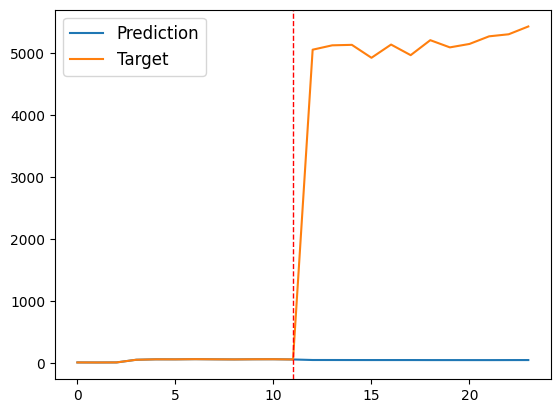

In [ ]:
from matplotlib import pyplot as plt

target = (np.asarray(speed.iloc[12:24], dtype=np.float32)[:, 0] * data_module.feat_max_val).tolist()
input = np.asarray(speed.iloc[:12], dtype=np.float32)[:, 0].tolist()

x = np.linspace(0, 24, 24)


plt.plot(input + predictions[:,0].tolist(), label='Prediction')
plt.plot(input + target, label='Target')

plt.legend(fontsize=12)
ax = plt.gca()
# Add a vertical line at the start of the input
plt.axvline(x=11, color='red', linestyle='--', linewidth=1, label='Input Start')

# ax.set_xlim([xmin, xmax])
# ax.set_ylim([0, data_module.feat_max_val])

Validating:   0%|          | 0/1 [00:00<?, ?it/s]


[68.625, 68.66666412353516, 68.44444274902344, 68.0, 69.25, 68.625, 67.625, 67.625, 67.44444274902344, 68.0, 68.33333587646484, 67.875]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]


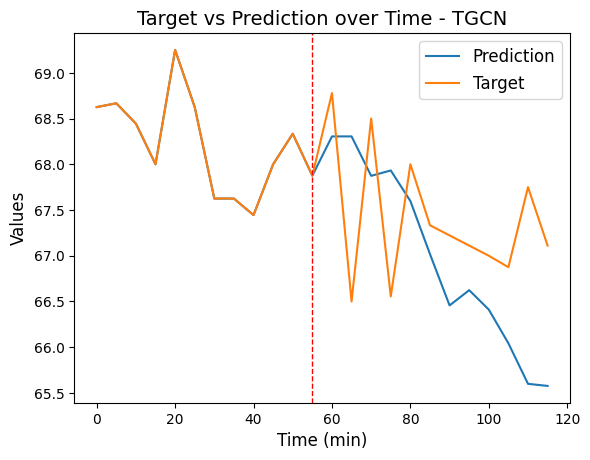

In [ ]:
with torch.no_grad():
    for batch in tqdm(data_module.val_dataloader(), desc="Validating"):
        x, y = batch
        x, y = x.to(trainer.device), y.to(trainer.device)
        # print(x.shape, y.shape)
        x = x[200].reshape(1, -1, x.size(2))
        y = y[200].reshape(1, -1, y.size(2))

        predictions = trainer.forward(x)
        predictions = predictions * data_module.feat_max_val
        y = y * data_module.feat_max_val

        predictions = predictions.transpose(1, 2).reshape((-1, x.size(2)))  # Reshape predictions
        y = y.reshape((-1, y.size(2)))  # Reshape targets



        input = x[0][:, 0].tolist()

        pred = predictions[:, 0].tolist()
        target = y[:, 0].tolist()
        print(input)
        x = [i for i in range(0, 120, 5)]
        print(x)
        plt.plot(x, input + pred, label='Prediction')
        plt.plot(x, input + target, label='Target')

        plt.legend(fontsize=12)
        plt.axvline(x=55, color='red', linestyle='--', linewidth=1)

        # Add a vertical line at the start of the input
        plt.xlabel('Time (min)', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.title('Target vs Prediction over Time - TGCN', fontsize=14)



        break

In [ ]:
validate(trainer, data_module.val_dataloader())

Validating: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

Validation Loss: 37.4324, RMSE: 6.1182, MAE: 4.5519, R2: 0.6570, Explained Variance: 0.6570 Accuracy: 0.5734


In [ ]:
torch.save(trainer.model.state_dict(), "/content/TGCN.pkl")

In [ ]:
test = TGCN(data_module.adj, hidden_dim)
test.load_state_dict(torch.load("/content/TGCN.pkl", weights_only=True))
test.eval()

TGCN(
  (tgcn_cell): TGCNCell(
    (graph_conv1): TGCNGraphConvolution()
    (graph_conv2): TGCNGraphConvolution()
  )
)

In [ ]:
def compute_time_series_pearson_with_running_mean(adj_matrix, feature_series):
    """
    Compute Pearson correlation matrices for a time series of features using a running mean for neighbor aggregation.

    Args:
        adj_matrix (np.ndarray): Adjacency matrix of shape (n, n).
        feature_series (list[np.ndarray]): List of feature matrices for time steps 1, ..., T.
                                           Each feature matrix has shape (n, d).

    Returns:
        list[np.ndarray]: List of Pearson correlation matrices for each time step t in feature_series.
                          Each matrix has shape (n, d).
    """
    n, d = feature_series[0].shape
    T = len(feature_series)
    correlations_list = []

    # Remove self-loops from adjacency matrix
    # adj_matrix_no_self = adj_matrix - np.eye(n)
    adj_matrix_no_self = adj_matrix


    # Initialize running mean and standard deviation for neighbors
    running_mean_neighbors = np.zeros((n, d))
    running_var_neighbors = np.zeros((n, d))  # Variance to compute std deviation

    for t in range(T):
        # Current feature set for Graph 2
        features2 = feature_series[t] # 207 x 1

        # Update running mean and variance for neighbors
        if t == 0:
            running_mean_neighbors = features2  # Initialize with the first timestep
            running_var_neighbors = np.zeros_like(features2)
            correlations_list.append(features2)
            continue
        else:
            delta = features2 - running_mean_neighbors
            running_mean_neighbors = (running_mean_neighbors * t + features2) / (t + 1)
            running_var_neighbors += delta ** 2

        # Compute standard deviation for neighbors
        running_std_neighbors = np.sqrt(running_var_neighbors / max(1, t))

        # Compute correlation for current time step
        correlations = np.zeros((n, d))

        for i in range(n):
            # Find neighbors of node i
            neighbors = np.where(adj_matrix_no_self[i] > 0)[0]
            if len(neighbors) == 0:
                continue  # Skip if no neighbors

            # Use running mean of neighbors for aggregation
            neighbor_features = running_mean_neighbors[neighbors]  # Shape: (|N_i|, d)

            # Feature of node i in Graph 2 (current time step)
            node_feature2 = features2[i]  # Shape: (d,)

            # Center the data
            neighbor_mean = np.mean(neighbor_features, axis=0)  # Shape: (d,)
            centered_neighbors = neighbor_features - neighbor_mean  # Shape: (|N_i|, d)
            centered_node = node_feature2 - running_mean_neighbors[i]  # Shape: (d,)
            centered_node = centered_node.reshape(1, d)
            # print(neighbor_features.shape)
            # print(neighbor_mean.shape)
            # print(centered_neighbors.shape)
            # print(node_feature2)
            # print(running_mean_neighbors[i])
            # print(centered_node.shape, centered_neighbors.shape)

            # Compute standard deviations
            neighbor_std = np.std(neighbor_features, axis=0)  # Shape: (d,)
            node_std = np.std(node_feature2)  # Scalar

            # Avoid division by zerossss
            neighbor_std[neighbor_std == 0] = 1e-8
            node_std = node_std if node_std > 0 else 1e-8


            # Compute Pearson correlation
            correlation = np.sum(abs(centered_node) * abs(centered_neighbors)) / ((len(neighbors)) * neighbor_std * node_std)
            # correlation = np.sum(abs(centered_node) * abs(centered_neighbors)) / ((len(neighbors)))
            correlations[i] = correlation

        # Append correlation matrix for this time step
        correlations_list.append(correlations)

    return correlations_list

In [ ]:
dm = data_module._feat.reshape(-1, 207, 1)

In [ ]:
input = []

for arr in dm:
  input.append(arr)


In [ ]:
arr = compute_time_series_pearson_with_running_mean(data_module.adj, input)

In [ ]:
arr[1]

array([[3.48928250e+06],
       [1.75176160e+08],
       [6.43420880e+07],
       [3.93048064e+08],
       [5.46608256e+08],
       [3.94193408e+08],
       [2.18437856e+08],
       [7.24085920e+07],
       [1.34417696e+08],
       [2.25072368e+08],
       [1.01708776e+08],
       [2.07030064e+08],
       [1.04166317e+09],
       [4.00712880e+07],
       [1.56052210e+07],
       [5.84490688e+08],
       [2.74253600e+08],
       [2.68026848e+08],
       [2.80917888e+08],
       [2.63561280e+08],
       [2.47711220e+07],
       [1.42642560e+08],
       [8.30132560e+07],
       [1.06916840e+07],
       [9.35533040e+07],
       [2.01564720e+08],
       [0.00000000e+00],
       [2.93841094e+04],
       [8.41922880e+07],
       [1.38583120e+08],
       [3.72462400e+08],
       [8.28017520e+07],
       [1.29191816e+08],
       [3.24299904e+08],
       [1.72657920e+08],
       [2.59617824e+08],
       [1.02062992e+08],
       [4.17176200e+07],
       [6.33567488e+08],
       [1.64187936e+08],


In [ ]:
feat = np.stack(arr, axis=0)

In [ ]:
feat = feat.reshape(-1, 207)

In [ ]:
feat

array([[6.27628021e+01, 6.44160995e+01, 6.39782410e+01, ...,
        5.76971169e+01, 6.42414246e+01, 5.72315521e+01],
       [3.48928250e+06, 1.75176160e+08, 6.43420880e+07, ...,
        5.68138040e+07, 1.70234784e+08, 2.25953152e+08],
       [6.82234720e+07, 1.46510368e+08, 2.49167776e+08, ...,
        1.99697888e+08, 1.90969104e+08, 1.02007280e+08],
       ...,
       [2.96991328e+08, 1.49935632e+08, 1.85502700e+07, ...,
        2.00731648e+08, 4.69504384e+08, 4.31071936e+08],
       [1.56549056e+08, 1.63655040e+08, 2.39252848e+08, ...,
        1.19760904e+08, 3.56766784e+08, 4.73874720e+08],
       [2.65937936e+08, 2.07071680e+08, 1.96925904e+08, ...,
        7.21294960e+07, 3.49324576e+08, 1.37643408e+08]])

In [ ]:
covariance_dataset = SpatioTemporalCSVDataModule("/content/los_speed.csv", "/content/los_adj.csv", features=feat, adj_matrix=data_module.adj)

In [ ]:
trainer = SupervisedForecastTask(model, feat_max_val=covariance_dataset.feat_max_val)

In [ ]:
trainer.train(covariance_dataset.train_dataloader(), covariance_dataset.val_dataloader(), 10)

Epoch 1/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


Epoch 1/10 - Training Loss: 0.0609


Epoch 2/10 - Training: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch 2/10 - Training Loss: 0.0476


Epoch 3/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch 3/10 - Training Loss: 0.0536


Epoch 4/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch 4/10 - Training Loss: 0.0489


Epoch 5/10 - Training: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch 5/10 - Training Loss: 0.0371


Epoch 6/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


Epoch 6/10 - Training Loss: 0.0427


Epoch 7/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


Epoch 7/10 - Training Loss: 0.0382


Epoch 8/10 - Training: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Epoch 8/10 - Training Loss: 0.0479


Epoch 9/10 - Training: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch 9/10 - Training Loss: 0.0346


Epoch 10/10 - Training: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]

Epoch 10/10 - Training Loss: 0.0452


In [ ]:
with torch.no_grad():
    for batch in tqdm(covariance_dataset.val_dataloader(), desc="Validating"):
        x, y = batch
        # x, y = x, y
        print(x.shape)
        print(y.shape)
        predictions = trainer.forward(x)
        print(predictions)
        break

In [ ]:
# 15-min Validating: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]Validation Loss: 29.0100, RMSE: 5.3861, MAE: 3.5388, R2: 0.8495, Explained Variance: 0.8514 Accuracy: 0.9083
# 30-min Validating: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]Validation Loss: 58.2098, RMSE: 7.6295, MAE: 5.0990, R2: 0.6986, Explained Variance: 0.6986 Accuracy: 0.8701

# 45-min Validating: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]Validation Loss: 69.1587, RMSE: 8.3162, MAE: 5.4171, R2: 0.6448, Explained Variance: 0.6479 Accuracy: 0.8583
# 60-min Validating: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]Validation Loss: 78.9497, RMSE: 8.8854, MAE: 5.7577, R2: 0.5952, Explained Variance: 0.5973 Accuracy: 0.8486

In [ ]:
# SZ-taxi
# 15min Validating: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]Validation Loss: 35.9434, RMSE: 5.9953, MAE: 4.4205, R2: 0.6706, Explained Variance: 0.6706 Accuracy: 0.5822
